In [2]:
from ultralytics import YOLO
import supervision as sv

import cv2
import yaml
import torch
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from tools.video_info import from_video_path

from icecream import ic

In [8]:
# Load input parameters
source: str = 'D:/Data/Piloto_RC_2024/C7_output.csv'
total_frames = 5000
with open(source, 'r') as csv_file:
    csv_data = pd.read_csv(
        filepath_or_buffer=csv_file,
        sep=',',
        names=['frame', 'id', 'class', 'x', 'y', 'w', 'h', 'score'],
        header=0,
        index_col=False
    )
csv_data

,frame,id,class,x,y,w,h,score
0,1,NaN,motorbike,261.53406,276.07672,46.012573,99.950440,0.891743
1,1,NaN,truck,212.67404,368.26608,203.268070,272.930450,0.634355
2,1,NaN,car,213.13400,367.85060,203.522580,274.071780,0.604400
3,2,NaN,motorbike,261.68616,276.53723,45.825195,99.488040,0.891158
4,2,NaN,truck,212.86783,367.47607,203.067380,273.589970,0.709430
...,...,...,...,...,...,...,...,...
351618,590765,NaN,car,689.63050,130.23978,46.436035,82.900300,0.680756
351619,590766,NaN,car,689.63890,130.23721,46.419190,82.897460,0.681705
351620,590767,NaN,car,689.62805,130.20378,46.430910,82.953580,0.660009
351621,590768,NaN,car,688.81260,129.01242,46.413820,82.069214,0.620674


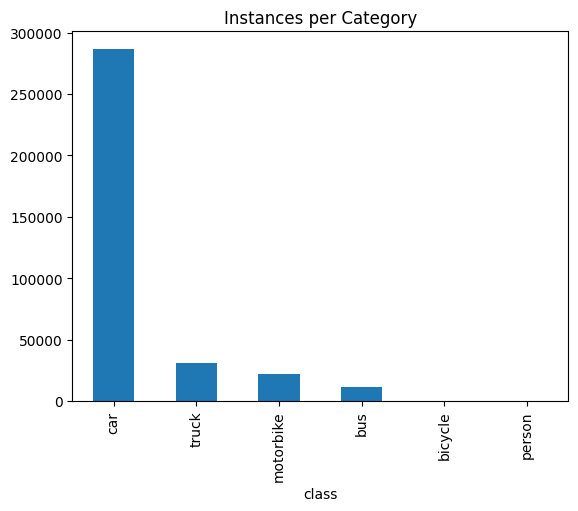

In [9]:
class_count = csv_data['class'].value_counts()
class_count.plot(kind='bar')
plt.title('Instances per Category')
plt.show()

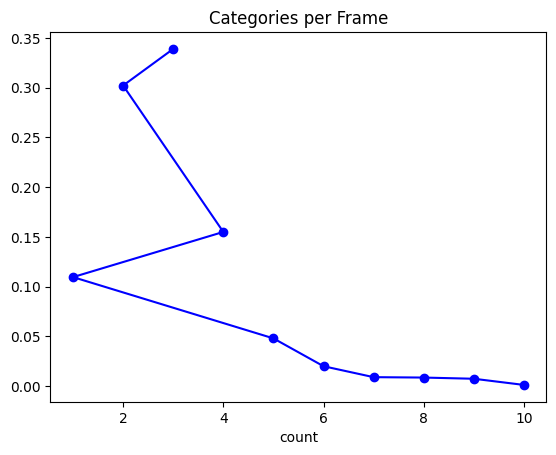

In [56]:
frame_count = csv_data.groupby(['frame'])['class'].agg(['count']).reset_index()
category_count = frame_count['count'].value_counts()
category_count = category_count / total_frames
category_count.plot(linestyle='-', marker='o', color='b')
plt.title("Categories per Frame")
plt.show()

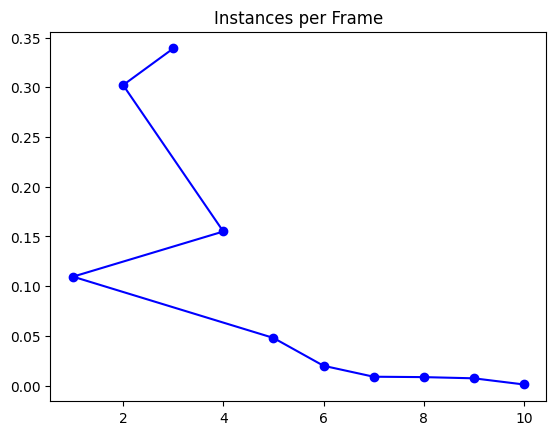

In [57]:
instance_count = csv_data.groupby('frame').size()
instance_count = instance_count.value_counts() / total_frames
instance_count.plot(linestyle='-', marker='o', color='b')
plt.title('Instances per Frame')
plt.show()

In [58]:
car_class = csv_data[csv_data['class'] == 'car'].copy().reset_index()
car_class

,index,frame,id,class,x,y,w,h,score
0,0,0,NaN,car,1049.85230,390.64423,123.864746,140.770510,0.938043
1,1,1,NaN,car,1049.76150,390.80690,123.227050,140.381230,0.939039
2,2,1,NaN,car,588.25500,295.35160,136.499880,422.602260,0.262170
3,3,2,NaN,car,1049.79250,390.60742,123.080080,140.194820,0.940582
4,4,2,NaN,car,588.01450,294.68860,136.868770,423.226200,0.273416
...,...,...,...,...,...,...,...,...,...
13334,14602,4998,NaN,car,747.71520,230.86462,54.149902,63.071655,0.926287
13335,14603,4998,NaN,car,593.68740,292.94740,130.578740,424.482060,0.445679
13336,14604,4999,NaN,car,1049.49630,390.95215,124.711914,141.154720,0.935489
13337,14605,4999,NaN,car,747.71533,230.86365,54.149902,63.074340,0.926280


In [59]:
truck_class = csv_data[csv_data['class'] == 'truck'].copy().reset_index()
truck_class

,index,frame,id,class,x,y,w,h,score
0,488,247,NaN,truck,739.91223,236.940920,65.039920,70.714480,0.511707
1,491,248,NaN,truck,738.03040,227.097780,61.189210,68.594480,0.565415
2,494,249,NaN,truck,732.73720,206.691010,52.871094,57.087950,0.883403
3,496,250,NaN,truck,729.63837,192.887180,50.514038,54.682190,0.270920
4,500,252,NaN,truck,726.71826,188.748570,50.044190,52.086945,0.432175
...,...,...,...,...,...,...,...,...,...
592,12625,4151,NaN,truck,695.51230,66.906080,26.369507,36.657593,0.328930
593,12628,4152,NaN,truck,695.58386,67.037980,26.353516,36.399140,0.339603
594,12632,4153,NaN,truck,695.57980,66.998740,26.375610,36.462770,0.373211
595,12636,4154,NaN,truck,695.58453,67.006090,26.352905,36.455383,0.379032


In [60]:
motorbike_class = csv_data[csv_data['class'] == 'motorbike'].copy().reset_index()
motorbike_class

,index,frame,id,class,x,y,w,h,score
0,410,217,NaN,motorbike,1015.87680,474.47522,51.780212,90.454346,0.630075
1,413,218,NaN,motorbike,1015.90894,474.47906,51.726562,90.600950,0.614489
2,417,219,NaN,motorbike,1003.40020,451.57820,46.419860,82.501950,0.893259
3,421,220,NaN,motorbike,989.82250,429.13342,45.098633,78.582150,0.848828
4,425,221,NaN,motorbike,978.10310,403.85342,41.882324,80.678955,0.720825
...,...,...,...,...,...,...,...,...,...
524,13522,4538,NaN,motorbike,347.59183,342.47577,35.221558,78.362120,0.650134
525,13526,4539,NaN,motorbike,347.60223,342.36456,35.233765,78.466430,0.665218
526,13540,4543,NaN,motorbike,280.54492,419.25890,45.682373,92.700320,0.357086
527,13548,4547,NaN,motorbike,228.63293,486.68850,49.511870,101.968960,0.618097


In [61]:
bus_class = csv_data[csv_data['class'] == 'bus'].copy().reset_index()
bus_class

,index,frame,id,class,x,y,w,h,score
0,89,49,NaN,bus,52.710190,102.516600,80.957535,101.82242,0.253680
1,99,58,NaN,bus,52.201800,102.604645,81.196840,101.56152,0.260988
2,101,59,NaN,bus,52.405197,102.600610,81.059050,101.48359,0.255196
3,238,131,NaN,bus,53.627580,102.612360,82.657990,101.61915,0.256763
4,415,218,NaN,bus,54.950460,101.861980,81.064640,102.17602,0.253133
...,...,...,...,...,...,...,...,...,...
137,14202,4841,NaN,bus,53.018307,102.554504,82.494965,103.59158,0.253646
138,14209,4844,NaN,bus,53.498657,103.077730,81.801560,103.29813,0.254828
139,14212,4845,NaN,bus,53.399567,103.028915,81.848420,103.32672,0.268287
140,14215,4846,NaN,bus,53.426178,103.075220,81.861240,103.29871,0.265930


In [62]:
bicycle_class = csv_data[csv_data['class'] == 'bicycle'].copy().reset_index()
bicycle_class

,index,frame,id,class,x,y,w,h,score


In [63]:
person_class = csv_data[csv_data['class'] == 'person'].copy().reset_index()
person_class

,index,frame,id,class,x,y,w,h,score


In [64]:
car_mean_score = car_class['score'].min()
car_mean_score

0.25035763

In [65]:
truck_mean_score = truck_class['score'].min()
truck_mean_score

0.25621778

In [66]:
motorbike_mean_score = motorbike_class['score'].min()
motorbike_mean_score

0.25018772

In [67]:
bus_mean_score = bus_class['score'].min()
bus_mean_score


0.25008395

In [68]:
bicycle_mean_score = bicycle_class['score'].min()
bicycle_mean_score


nan

In [69]:
person_mean_score = person_class['score'].mean()
person_mean_score

nan

In [70]:
result = csv_data.groupby(['frame'])['score'].agg(['count', 'mean']).reset_index()
result

,frame,count,mean
0,0,1,0.938043
1,1,2,0.600604
2,2,2,0.606999
3,3,2,0.622110
4,4,2,0.607321
...,...,...,...
4995,4995,3,0.771577
4996,4996,3,0.769279
4997,4997,3,0.770925
4998,4998,3,0.769151


In [8]:
top_score = result.sort_values('mean', ascending=True).head(20)
top_score

,frame,count,mean
215495,487646,1,0.500002
35579,83554,1,0.500006
91966,193325,1,0.500006
167364,343563,1,0.500014
127126,261385,1,0.500019
201652,444496,1,0.500024
219406,504006,1,0.500026
43763,99281,1,0.500027
213113,479210,1,0.500032
239427,576270,1,0.500035


In [9]:
top_count = result.sort_values('count', ascending=False).head(10)
top_count

,frame,count,mean
77890,169877,7,0.783109
78055,170052,7,0.793332
87472,185019,7,0.769849
87473,185020,7,0.762494
87474,185021,7,0.763283
87475,185022,7,0.762879
87476,185023,7,0.792610
87480,185027,7,0.744986
57535,122969,7,0.773403
57536,122970,7,0.774172


In [10]:
object_data = result[result['mean'] < 0.7].copy()
object_data

,frame,count,mean
49,188,1,0.567820
55,194,1,0.562817
58,197,1,0.506468
59,198,1,0.598589
60,199,1,0.620848
...,...,...,...
243401,590765,1,0.680756
243402,590766,1,0.681705
243403,590767,1,0.660009
243404,590768,1,0.620674


In [11]:
object_count = object_data[object_data['count'] > 4].copy()
object_count

,frame,count,mean
19269,48709,5,0.695982
24336,60358,5,0.695815
26494,63903,5,0.663258
26643,64052,5,0.664761
26644,64053,5,0.666542
...,...,...,...
202520,447925,5,0.673742
202521,447926,6,0.691933
204782,454759,5,0.676712
209637,469264,5,0.675965


In [12]:
frame_list = object_count['frame'].to_list()
frame_list

[48709,
 60358,
 63903,
 64052,
 64053,
 64054,
 64132,
 73268,
 73272,
 76086,
 87337,
 87340,
 87341,
 87342,
 87343,
 87344,
 87345,
 87346,
 87347,
 107479,
 107543,
 113015,
 115618,
 116040,
 116969,
 116971,
 116972,
 136475,
 143183,
 163940,
 163943,
 166753,
 166754,
 169828,
 169837,
 177541,
 177542,
 178582,
 178583,
 179031,
 183048,
 190025,
 219908,
 219911,
 221446,
 229437,
 229438,
 229753,
 229768,
 229973,
 229979,
 240692,
 240693,
 240711,
 240718,
 260483,
 268368,
 268627,
 268648,
 270564,
 270565,
 270588,
 276544,
 276806,
 276811,
 276812,
 276843,
 286410,
 286411,
 287800,
 290419,
 293307,
 293308,
 293310,
 293473,
 293480,
 294995,
 304429,
 324034,
 324036,
 327221,
 433974,
 433975,
 447924,
 447925,
 447926,
 454759,
 469264,
 469265]

In [36]:
weights = 'D:/Data/models/yolov8/yolov8x_cf_v5.pt'
model = YOLO(weights)

In [37]:
video_source_path = "D:/Data/Piloto_RC_2024/C2_source.mp4"
cap = cv2.VideoCapture(video_source_path)
source_info = from_video_path(cap)

In [38]:
# Annotators
line_thickness = int(sv.calculate_optimal_line_thickness(resolution_wh=(source_info.width, source_info.height)) * 0.5)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=(source_info.width, source_info.height)) * 0.5

label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_padding=2, text_position=sv.Position.TOP_LEFT, text_thickness=line_thickness)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=line_thickness)

In [39]:
frame_number = 0
while cap.isOpened():
    print(frame_number, end="", flush=True)
    success, image = cap.read()
    if frame_number in frame_list:
        annotated_image = image.copy()
        results = model(
            source=image,
            imgsz=640,
            conf=0.25,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=False
        )[0]
        detections = sv.Detections.from_ultralytics(results)

        detections

        # Draw labels
        object_labels = [f"{data['class_name']} ({score:.2f})" for _, _, score, _, _, data in detections]
        annotated_image = label_annotator.annotate(
            scene=annotated_image,
            detections=detections,
            labels=object_labels )
        
        # Draw boxes
        annotated_image = bounding_box_annotator.annotate(
            scene=annotated_image,
            detections=detections )
        
        cv2.imshow("Output", annotated_image)
        cv2.waitKey(0)
        
    frame_number += 1

cv2.destroyAllWindows()
cap.release()




        
    

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348

KeyboardInterrupt: 